In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import copy
import torch

from utils.visualization import display_image_pair
from utils.dataset import read_config, load_dataset
from utils.correspondence import preprocess_image, preprocess_points, preprocess_bbox, compute_pck, postprocess_points

from models.luo import LuoModel
from models.hedlin import HedlinModel
from models.tang import TangModel
from models.zhang import ZhangModel

In [62]:
model_type = 'hedlin'
dataset_config = 'dataset_config.json'
device_type = 'cuda'
pck_threshold = 0.1

In [63]:
# Load model
if model_type == 'luo':
    image_size = (224, 224)
    model = LuoModel(1, image_size, device_type)
elif model_type == 'hedlin':
    image_size = (512, 512)
    model = HedlinModel(image_size, device_type)
elif model_type == 'tang':
    image_size = (768, 768)
    model = TangModel(image_size, device_type)
elif model_type == 'zhang':
    image_size = (960, 960)
    batch_size = 1
    model = ZhangModel(1, image_size, device_type)

device = torch.device(device_type)
model.to(device)

# Load dataset config
dataset_config = read_config(dataset_config)

# Define preprocessor
def preprocess(sample):
    source_size = sample['source_image'].size
    target_size = sample['target_image'].size
    sample['source_image'] = preprocess_image(sample['source_image'], image_size)
    sample['target_image'] = preprocess_image(sample['target_image'], image_size)
    sample['source_points'] = preprocess_points(sample['source_points'], source_size, image_size)
    sample['target_points'] = preprocess_points(sample['target_points'], target_size, image_size)
    sample['source_bbox'] = preprocess_bbox(sample['source_bbox'], source_size, image_size)
    sample['target_bbox'] = preprocess_bbox(sample['target_bbox'], target_size, image_size)
    return sample

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Evaluating dataset: SPair-71k


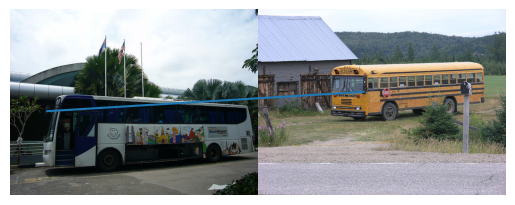

In [64]:
# Evaluate
config = dataset_config[0]
print(f"Evaluating dataset: {config['name']}")
dataset = load_dataset(config)

# Take first sample
unprocessed_sample = dataset[0]

# Use only 1 keypoint for Hedlin et al. because of time constraints
if model_type == 'hedlin':
    rand_i = torch.randint(0, unprocessed_sample['source_points'].shape[0], (1,)).item()
    unprocessed_sample['source_points'] = unprocessed_sample['source_points'][rand_i, :].unsqueeze(0)
    unprocessed_sample['target_points'] = unprocessed_sample['target_points'][rand_i, :].unsqueeze(0)

# Visualize sample
display_image_pair(unprocessed_sample)

# Preprocess sample
sample = preprocess(copy.deepcopy(unprocessed_sample))
source_images = sample['source_image'].unsqueeze(0)
target_images = sample['target_image'].unsqueeze(0)
source_points = sample['source_points'].unsqueeze(0)
target_points = sample['target_points'].unsqueeze(0)
source_bbox = sample['source_bbox'].unsqueeze(0)
target_bbox = sample['target_bbox'].unsqueeze(0)

# load images on device
source_images, target_images = source_images.to(device), target_images.to(device)

In [65]:
# run through model
with torch.set_grad_enabled(model_type == 'hedlin'):
    predicted_points = model(source_images, target_images, source_points)

optimization took 19.35975217819214 seconds
optimization took 19.43862509727478 seconds
optimization took 19.109966039657593 seconds
optimization took 19.128482341766357 seconds
optimization took 18.855170965194702 seconds


Preprocessed/Predicted: [228.01067 218.11201] [  6.5 142.5]
Unprocessed/Postprocessed: [213. 167.] [139.16016    4.760742]


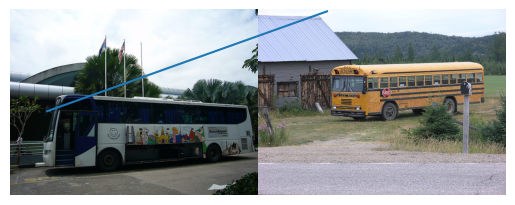

In [66]:
predicted_sample = copy.deepcopy(unprocessed_sample)
predicted_sample['target_points'] = postprocess_points(predicted_points[0], image_size, unprocessed_sample['target_image'].size)

print("Preprocessed/Predicted:", sample['target_points'][0].numpy(), predicted_points[0, 0].numpy())
print("Unprocessed/Postprocessed:", unprocessed_sample['target_points'][0].numpy(), predicted_sample['target_points'][0].numpy())

display_image_pair(predicted_sample)

In [67]:
# calculate PCK values
pck_img = compute_pck(predicted_points[0], target_points[0], image_size, pck_threshold)
pck_bbox = compute_pck(predicted_points[0], target_points[0], image_size, pck_threshold, target_bbox[0])
keypoints = len(source_points[0])

print(f"pck_img: {pck_img / keypoints}, pck_bbox: {pck_bbox / keypoints}")

pck_img: 0.0, pck_bbox: 0.0
